# Redesigning IT Service Catalog Using Latent Dirichlet Allocation (Topic Modeling)

### Imports

In [548]:
# Standard imports
import numpy as np
import pandas as pd
import re
import warnings
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy # Plotting tools
import guidedlda
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import logging, sys
logging.disable(sys.maxsize)

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 60

### Load Data

In [549]:
df = pd.read_excel('service catalog.xlsx', 'service catalog')
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()
df.head(5)

,request_item,number,priority,state,short_description,assignment_group,assigned_to,configuration_item,item,active,category
0,RITM2664264,SCTASK2871261,4 - Low,Open,Need support on Prod issue for BoricAcid,LEIDOS-SQL SERVER SUPPORT,NaN,NaN,Assistance,True,Request Application Support
1,RITM2664263,SCTASK2871260,4 - Low,Open,one drive documents - Missing,Atos.L1.Service.Desk,NaN,NaN,Generic IT Service Request,True,Service Desk
2,RITM2664262,SCTASK2871258,4 - Low,Open,Webex - need license,Atos.ZZ.Voice.Webex.Lv2,NaN,NaN,Generic IT Service Request,True,Service Desk
3,RITM2664261,SCTASK2871257,4 - Low,Open,Please remove Gregory Camet (GCAMET) from all ...,ENTERPRISE CONTENT MGMT,NaN,DOCUMENTUM - ENTERPRISE CONTENT,Assistance,True,Request Application Support
4,RITM2664253,SCTASK2871249,4 - Low,Work in Progress,User needs access to epoch electric for all 4 ...,ESRI-Enterprise GIS,Baohua Tao,NaN,Generic IT Service Request,True,Service Desk


### Topic Modeling Using Sklearn

In [550]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = cv.fit_transform(df['short_description'])

In [551]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components = 7,random_state = 42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

In [552]:
print(len(LDA.components_),type(LDA.components_))

topics = []
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    topic = [cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
    topics.append(topic)
    print('\n')

# topics_df = pd.DataFrame(topics, columns = ["Topics"])
topics_df = pd.DataFrame({0: topics})

7 <class 'numpy.ndarray'>
THE TOP 15 WORDS FOR TOPIC #0
['jobs', 'box', 'sap', 'ucr', 'pc', 'old', 'id', 'ccs', 'needs', 'forcestart', 'access', 'user', 'job', 'request', 'update']


THE TOP 15 WORDS FOR TOPIC #1
['2023', 'autosys', 'job', 'laptop', 'dump', '25', 'user', 'vulnerability', 'week', 'maximo', 'add', 'report', 'ot', 'group', 'ad']


THE TOP 15 WORDS FOR TOPIC #2
['report', 'add', 'disable', 'bi', 'attn', 'token', 'create', 'pc', 'support', 'new', 'id', 'user', 'refresh', 'power', 'error']


THE TOP 15 WORDS FOR TOPIC #3
['unix', 'meter', 'box', 'account', 'test', 'dq0', 'present', 'jan', '2019', 'tr', 'like', 'khunter', 'user', 'billing', 'request']


THE TOP 15 WORDS FOR TOPIC #4
['replaced', 'lvp', 'longer', 'june', 'request', 'aaa', 'expired', 'locked', 'user', 'order', 'following', 'update', 'access', 'sap', 'ccs']


THE TOP 15 WORDS FOR TOPIC #5
['epoch', 'share', 'project', 'job', 'drive', 'idmhub', 'app', 'webex', 'hub', 'idm', 'request', 'user', 'access', 'reset', '

### Topic Modeling Using Gensim LDA

#### Data Preprocessing

In [553]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [554]:
data = df.short_description.values.tolist()
# Remove distracting single quotes 
data = [re.sub("\"", "", sent) for sent in data]  

In [555]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))

In [556]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [557]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [558]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = data_words_bigrams

In [559]:
# Create Dictionary 

{
    "tags": [
        "hide-output"
    ]
}

id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# Vocab 
vocab = [element for nestedlist in data_lemmatized for element in nestedlist]


#### Build Model

In [560]:
# Find optimal number of topics
for i in range(5,30):
    num_topics = i
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = i, 
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)
    perplexity_score = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence ='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print("{} {} {}".format(i, perplexity_score, coherence_lda))

5 -7.180052912297185 0.5353334150167575
6 -7.209635616490741 0.5415332764355926
7 -7.245235977919639 0.5778489011508207
8 -7.270528627320348 0.5593125517401194
9 -7.24403317223848 0.5560888201374904
10 -7.289699982939611 0.5753356693148999
11 -7.2818502771470435 0.5233998007712647
12 -7.581387064837666 0.5561376732177123
13 -8.474437618649828 0.5334508057688148
14 -9.747834024233967 0.5052300235683093
15 -11.124084532775786 0.47969593978840164
16 -13.101294181651983 0.46536232244349474
17 -14.946247631648157 0.45601150879974517
18 -15.668189581130873 0.4803814287490316
19 -16.27492561850575 0.48754214885670216
20 -16.786837862323086 0.47339836913881356
21 -17.25870945443957 0.49417406458046015
22 -17.777120079414075 0.46458716175284936
23 -18.27233500287294 0.4748836030897306
24 -18.917445916084137 0.4669384653150441
25 -19.321976116063084 0.4758657294425637
26 -19.778818373553364 0.4571720002895579
27 -20.407638775235657 0.4750065647535904
28 -20.902329058448103 0.4696008795165669
29 

In [561]:
# Choose 3 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 3, 
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)            

In [562]:
# Print the keyword of topics

doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is, lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
pprint(lda_model.print_topics())


Perplexity:  -7.044847714871961

Coherence Score:  0.5069593923474259
[(0,
  '0.019*"request" + 0.018*"access" + 0.015*"webex" + 0.014*"unable" + '
  '0.012*"test" + 0.012*"project_name" + 0.012*"app_ems" + 0.012*"deployment" '
  '+ 0.011*"install" + 0.011*"error"'),
 (1,
  '0.032*"please" + 0.026*"access" + 0.024*"job" + 0.018*"user" + '
  '0.017*"request" + 0.016*"ccs" + 0.014*"update" + 0.013*"refresh" + '
  '0.013*"add" + 0.011*"needs"'),
 (2,
  '0.062*"password" + 0.054*"reset" + 0.043*"user" + 0.029*"request" + '
  '0.022*"sap" + 0.021*"like" + 0.021*"khunter_would" + 0.020*"pc" + '
  '0.016*"billing" + 0.014*"phone"')]


In [563]:
# Format final dataframe with topics 

def format_topics_sentences(ldamodel = None, corpus = corpus, texts = data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key = lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index = True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    # number_col = pd.Series(df["number"])
    sent_topics_df = pd.concat([sent_topics_df, contents], axis = 1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel = lda_model, corpus = corpus, texts = data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
number_col = pd.Series(df["number"])
df_dominant_topic = pd.concat([df_dominant_topic, number_col], axis = 1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', "number"]




In [564]:
total = pd.merge(df, df_dominant_topic, on = "number")
topics_df = total[["request_item", "short_description", "Document_No", "Dominant_Topic", "Topic_Perc_Contrib", "Keywords", "Text"]]

### Guided LDA

In [565]:
# Cleaning column
df["short_description"] = df["short_description"].apply(lambda x: x.replace("please", "").replace("Please", "").replace("thanks", "").replace("request", "").replace("Request", ""))

#### Data Preprocessing

In [566]:
# Data Preprocessing

{
    "tags": [
        "hide-output"
    ]
}


stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

data = df.short_description.values.tolist()

# Remove distracting single quotes 
data = [re.sub("\"", "", sent) for sent in data]  

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  #deacc=True removes punctuations
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = data_words_bigrams

# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  

# Create Corpus 
texts = data_lemmatized  
texts = data_words_bigrams

# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  

# Vocab List
vocab = [element for nestedlist in data_lemmatized for element in nestedlist]

#### Fit Model

In [567]:
vocab = tuple(set(vocab))

# Create the word to ID mapping
word2id = dict((v, idx) for idx, v in enumerate(vocab))

seed_topic_list = [['laptop', 'phone', 'pc', 'desktop', 'device', 'computer', "refresh", "old"],
                   ['webex', 'install', "application", "citrix", "license"],
                   ['account', 'password', "reset"]]


# Create the document-term matrix X
X = np.zeros((len(texts), len(word2id)), dtype = int)
for doc_idx, doc in enumerate(texts):
    for word in doc:
        word_idx = word2id[word]
        X[doc_idx, word_idx] += 1


# Model Fit
model = guidedlda.GuidedLDA(n_topics = 3, n_iter = 5000, random_state = 7, refresh = 20)

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X, seed_topics = seed_topics, seed_confidence = 0.15)

topic_word = model.topic_word_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    print('\n')
    print('Topic {} : {}'.format(i, ', '.join(topic_words)))




Topic 0 : pc, laptop, dq, user, dd, tr, access, move, refresh, number


Topic 1 : access, user, phone, khunter_would, like, needs, webex, need, billing, install


Topic 2 : password, reset, job, user, ccs, access, idm_hub, autosys, ad, idmhub


#### Output Data Frame

In [568]:
# Format Final Submission Dataframe 

topic_num_name = {"Topic 0":"devices",
                  "Topic 1":"access ",
                  "Topic 2":"password reset"}    

def get_doc_topics(model_glda, X, num_topics, dataframe, col_name):
    """
    A function which creates dataframe with documents, their dominant topic, along with their probabilities
    
    Parameters
    -------------
    model_glda - Guided LDA trained model
    X - Document term frequency table
    num_topics - Number of topics the model was trained for
    dataframe - Dataframe consisting of cleaned text column
    col_name - Column name in dataframe holding cleaned text
    
    Returns
    -------------
    A dataframe with document number, topic, probability of topic
    """
    df_doc_top = pd.DataFrame()
    final_list = []
    for index in range(len(dataframe[col_name])):
        word_id_dict = dict((x,y) for x,y in zip([x for x in range(num_topics)],np.round(model.transform(X[index])*100,1).tolist()[0]))
        word_score_list = []
        for index in range(num_topics):
            try:
                value = word_id_dict[index]
            except:
                value = 0
            word_score_list.append(value)
        final_list.append(word_score_list)

    df_doc_top = pd.DataFrame(final_list)
    df_doc_top.columns = ['Topic ' + str(i) for i in range(num_topics)]
    df_doc_top.index = ['Document ' + str(i) for i in range(len(dataframe[col_name]))]

    df_doc_top["Dominant_Topic"] = df_doc_top.idxmax(axis = 1).tolist()
    df_doc_top["Topic_Probability"] = df_doc_top.max(axis = 1).tolist()
    document_df = df_doc_top.reset_index().rename(columns = {"index":"Document"})[["Document","Dominant_Topic","Topic_Probability"]]
    return document_df




In [569]:

document_df = get_doc_topics(model, X, 3, df, "short_description")

In [570]:
submission = pd.concat([df.short_description, document_df.Dominant_Topic], axis = 1)

In [571]:
# Replace dominant topics with respective topic names
submission.Dominant_Topic = submission.Dominant_Topic.replace(topic_num_name)

In [572]:
# Fixing, reassigning incorrect words to correct topics

stemmer = PorterStemmer()

matches = ["access", "password", "webex", "phone", "laptop", "desktop", "computer", "office"]

for idx, desc in enumerate(submission["short_description"]):
    desc = stemmer.stem(desc)
    if not any([x in desc for x in matches]):
        submission["Dominant_Topic"][idx] = "Other"
    if "laptop" in desc or "desktop" in desc or "computer" in desc or "phone" in desc or "ipad" in desc or "pc" in desc or "phon" in desc or "hardware" in desc:
        submission["Dominant_Topic"][idx] = "devices"
    if "access" in desc or "webex" in desc:
        submission["Dominant_Topic"][idx] = "access"
    if "password" in desc or "pw reset" in desc:
        submission["Dominant_Topic"][idx] = "password reset"
    if idx == 456:
        submission["Dominant_Topic"][idx] = "access"

# Distribution of Topics
submission["Dominant_Topic"].value_counts().to_frame("Counts").reset_index(names = "Topics")


,Topics,Counts
0,Other,596
1,access,135
2,password reset,121
3,devices,88


##### "Other" Topic Data Frame

In [573]:
# Submission dataframe with only "Other" as the topic name
# Breaking down the "Other" into categories

submission_other = submission[submission["Dominant_Topic"] == "Other"]
submission_other = submission_other[["short_description", "Dominant_Topic"]]
submission_other.index.name = "INDEX"
submission_other = submission_other.reset_index(drop=True)

for idx, desc in enumerate(submission_other["short_description"]):
    stemmed = stemmer.stem(desc)
    if "update" in stemmed:
        submission_other["Dominant_Topic"][idx] = "Update"
    if "instal" in stemmed or "Instal" in desc:
        submission_other["Dominant_Topic"][idx] = "Install"
    if "job" in stemmed or "Job" in desc:
        submission_other["Dominant_Topic"][idx] = "Job"
    if "account" in stemmed or "Account" in desc:
        submission_other["Dominant_Topic"][idx] = "Account"

submission_other["Dominant_Topic"].value_counts().to_frame("Counts").reset_index(names = "Topics")

,Topics,Counts
0,Other,481
1,Job,47
2,Update,26
3,Install,22
4,Account,20


#### WordCloud of Topics

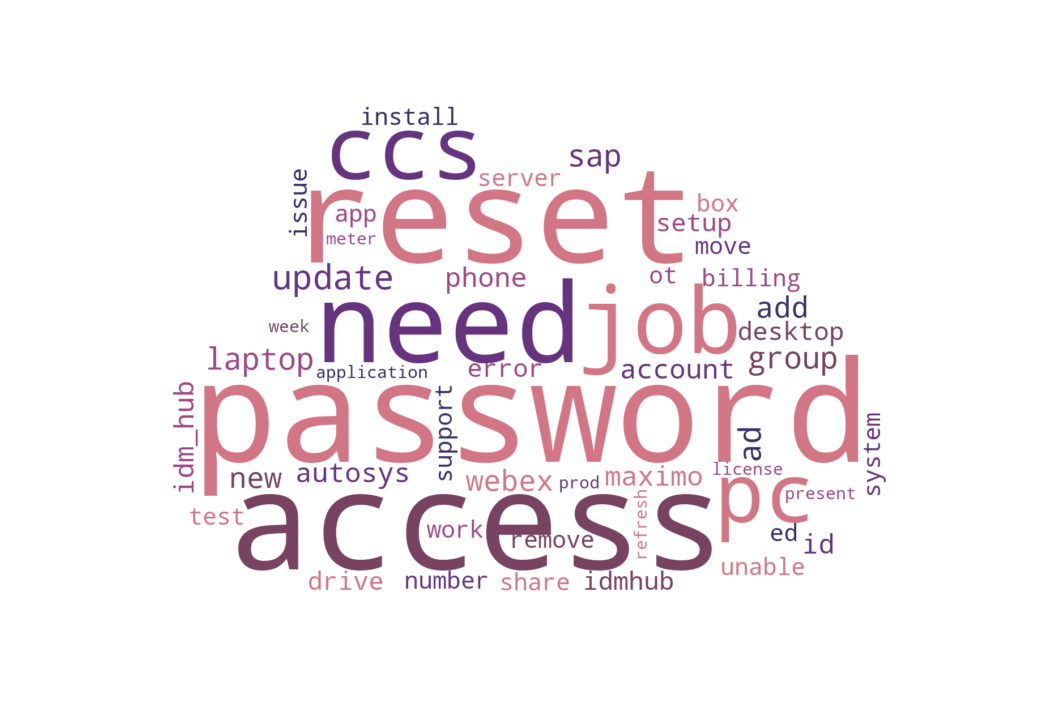

In [574]:
from wordcloud import WordCloud
from PIL import Image
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

joined = list(np.concatenate(data_lemmatized).flat)
unwanted = {'user', 'billing_jan', 'ing', 'bill_jan', 'khunter_would', 'tr', 'dd', 'dq'}
joined1 = [e for e in joined if e not in unwanted]
txt = " ".join(joined1)

mask = np.array(Image.open("C:/Users/khuang/Downloads/cloud4.jpg"))
word_cloud = WordCloud(background_color = 'white', width=6000, height=1000, max_words = 50, collocations=False,
                    mask = mask, scale = 3, colormap = "cmap1").generate(txt)

# Display the generated Word Cloud
plt.figure(figsize = (15, 9))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png', 
           transparent=True, bbox_inches='tight')
plt.show()

##### Create Custom Color Map

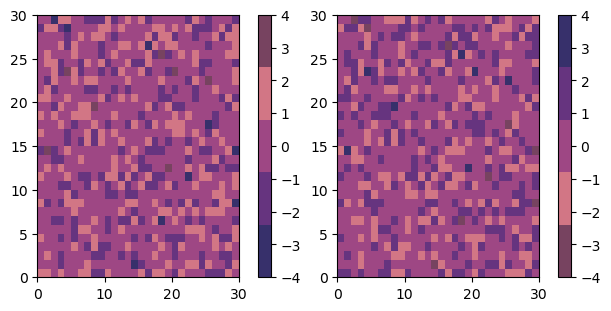

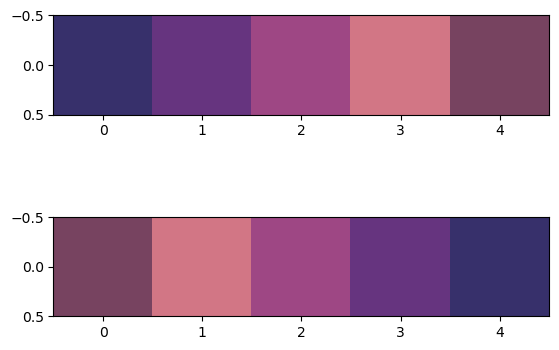

In [575]:
# Create custom colormap

def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize = (n * 2 + 2, 3),
                            constrained_layout = True, squeeze = False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap = cmap, rasterized = True, vmin = -4, vmax = 4)
        fig.colorbar(psm, ax = ax)
    plt.show()

colors = ["#37306B", "#66347F", "#9E4784", "#D27685", "#774360"]
c_map = ListedColormap(colors, name = "c_map")

c_map_r = c_map.reversed()

plot_examples([c_map, c_map_r])

# my_cmap, my_cmap_r from reversing a colormap
mpl.colormaps.register(cmap = c_map)
mpl.colormaps.register(cmap = c_map_r)

data = [[1, 2, 3, 4, 5]]

fig, (ax1, ax2) = plt.subplots(nrows = 2)

ax1.imshow(data, cmap = 'c_map')
ax2.imshow(data, cmap = 'c_map_r')

plt.show()